# Calculate Number of Tropical Nights

This notebook computes the Tropical Nights index: starting from the daily minimum temperature (2096-2100) TN,
the Tropical Nights index is the number of days where TN > T (T is  a reference temperature, e.g. 20°C)

In [1]:
# Load packages
import intake
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

Define Year

In [2]:
year = "2096"

Load Data Set via Intake

In [3]:
# Path to catalog descriptor on the DKRZ server
col_url = "/work/ik1017/Catalogs/mistral-cmip6.json"

# Open the catalog with the intake package and name it "col" as short for "collection"
col = intake.open_esm_datastore(col_url)

# This is how we tell intake what data we want

query = dict(
    source_id      = "MPI-ESM1-2-LR", # here we choose Max-Plack Institute's Earth Sytem Model in high resolution
    variable_id    = "tasmin", # temperature at surface, maximum
    table_id       = "day", # daily maximum
    experiment_id  = "ssp585", # what we selected in the drop down menu,e.g. SSP2.4-5 2015-2100
    member_id      = "r10i1p1f1", # "r" realization, "i" initialization, "p" physics, "f" forcing
)

# Intake looks for the query we just defined in the catalog of the CMIP6 data pool at DKRZ
cat = col.search(**query)

# Show query results
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path,opendap_url
0,ScenarioMIP,MPI-M,MPI-ESM1-2-LR,ssp585,r10i1p1f1,day,tasmin,gn,NaN,v20190710,20150101-20341231,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Sce...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/Scena...
1,ScenarioMIP,MPI-M,MPI-ESM1-2-LR,ssp585,r10i1p1f1,day,tasmin,gn,NaN,v20190710,20350101-20541231,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Sce...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/Scena...
2,ScenarioMIP,MPI-M,MPI-ESM1-2-LR,ssp585,r10i1p1f1,day,tasmin,gn,NaN,v20190710,20550101-20741231,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Sce...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/Scena...
3,ScenarioMIP,MPI-M,MPI-ESM1-2-LR,ssp585,r10i1p1f1,day,tasmin,gn,NaN,v20190710,20750101-20941231,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Sce...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/Scena...
4,ScenarioMIP,MPI-M,MPI-ESM1-2-LR,ssp585,r10i1p1f1,day,tasmin,gn,NaN,v20190710,20950101-21001231,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/Sce...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/Scena...


In [4]:
src_path = cat.df["path"][4] # this time range contains the selected year

Open Data Set

In [5]:
ds = xr.open_dataset(src_path)

# Open variable "tasmax" over the whole time range
ds_tasmin = ds["tasmin"]

Look at data set

In [6]:
ds_tasmin

<xarray.DataArray 'tasmin' (time: 2191, lat: 96, lon: 192)>
[40384512 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2095-01-01T12:00:00 ... 2100-12-31T12:00:00
  * lat      (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 83.0 84.86 86.72 88.57
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
    height   float64 ...
Attributes:
    standard_name:  air_temperature
    long_name:      Daily Minimum Near-Surface Air Temperature
    comment:        minimum near-surface (usually, 2 meter) air temperature (...
    units:          K
    cell_methods:   area: mean time: minimum
    cell_measures:  area: areacella
    history:        2019-11-15T00:39:34Z altered by CMOR: Treated scalar dime...

Select Year

In [7]:
ds_tasmin_year = ds_tasmin.sel(time=year)

Count the number of tropical nights

In [8]:
ds_tasmin_year_count = ds_tasmin_year.where(ds_tasmin_year > 293.15).count(dim='time')

Before plotting a cyclic point has to be added, otherwise there will be a gap at the prime meridian

In [9]:
lon = ds_tasmin_year_count.lon
lat = ds_tasmin_year_count.lat
ds_tasmin_year_count, lon = add_cyclic_point(ds_tasmin_year_count, lon)

Plot data with *cartopy*

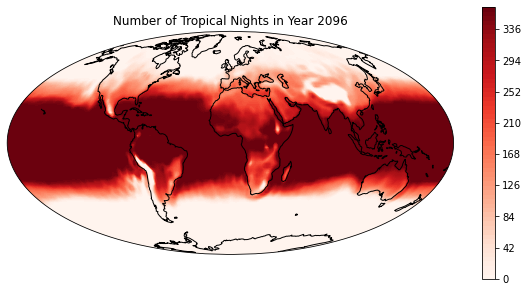

In [10]:
def main():
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide())

    plt.contourf(lon, lat, ds_tasmin_year_count, 60,
                transform=ccrs.PlateCarree(),
                cmap='Reds')
    ax.coastlines()
    ax.set_global()
    
    # Add a color bar
    plt.colorbar(ax=ax)
    plt.title('Number of Tropical Nights in Year ' +year)
    plt.show()


if __name__ == '__main__':
    main()